In [11]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import sys
from torchvision.transforms import ToTensor
import torch
from torch.utils.data import DataLoader

plt.style.use('seaborn-v0_8-darkgrid')


root = pathlib.Path().absolute().parent
DATASET_PATH = root / 'datasets'
sys.path.append(str(root))

from src.data.segmentation import LGGSegmentationDataset
from src.utils.visualize import plot_images_and_masks
from src.enums import DataSplit
from src.utils.transforms import DualInputTransform, DualInputCompose, DualInputResize


### LGG Dataset Exploration

Specifically looking at class inbalance....

In [2]:
LGG_PATH = DATASET_PATH / 'lgg-mri-segmentation'

train_info = pd.read_csv(LGG_PATH / 'train' / 'train.csv')
test_info = pd.read_csv(LGG_PATH / 'test' / 'test.csv')

# label 0: No-Tumor and 1: Tumor for Diagnosis Column
train_info['Diagnosis'] = train_info['Diagnosis'].map({0: 'No-Tumor', 1: 'Tumor'})
test_info['Diagnosis'] = test_info['Diagnosis'].map({0: 'No-Tumor', 1: 'Tumor'})

In [3]:
train_info.head()

,ID,Image,Mask,Diagnosis,Split
0,TCGA_DU_6399_19830416_1,TCGA_DU_6399_19830416_1.tif,TCGA_DU_6399_19830416_1_mask.tif,No-Tumor,train
1,TCGA_DU_6399_19830416_3,TCGA_DU_6399_19830416_3.tif,TCGA_DU_6399_19830416_3_mask.tif,No-Tumor,train
2,TCGA_DU_6399_19830416_4,TCGA_DU_6399_19830416_4.tif,TCGA_DU_6399_19830416_4_mask.tif,No-Tumor,train
3,TCGA_DU_6399_19830416_6,TCGA_DU_6399_19830416_6.tif,TCGA_DU_6399_19830416_6_mask.tif,No-Tumor,train
4,TCGA_DU_6399_19830416_7,TCGA_DU_6399_19830416_7.tif,TCGA_DU_6399_19830416_7_mask.tif,No-Tumor,train


In [4]:
test_info.head()

,ID,Image,Mask,Diagnosis,Split
0,TCGA_DU_6399_19830416_2,TCGA_DU_6399_19830416_2.tif,TCGA_DU_6399_19830416_2_mask.tif,No-Tumor,test
1,TCGA_DU_6399_19830416_5,TCGA_DU_6399_19830416_5.tif,TCGA_DU_6399_19830416_5_mask.tif,No-Tumor,test
2,TCGA_DU_6399_19830416_12,TCGA_DU_6399_19830416_12.tif,TCGA_DU_6399_19830416_12_mask.tif,No-Tumor,test
3,TCGA_DU_6399_19830416_20,TCGA_DU_6399_19830416_20.tif,TCGA_DU_6399_19830416_20_mask.tif,Tumor,test
4,TCGA_DU_6399_19830416_31,TCGA_DU_6399_19830416_31.tif,TCGA_DU_6399_19830416_31_mask.tif,Tumor,test


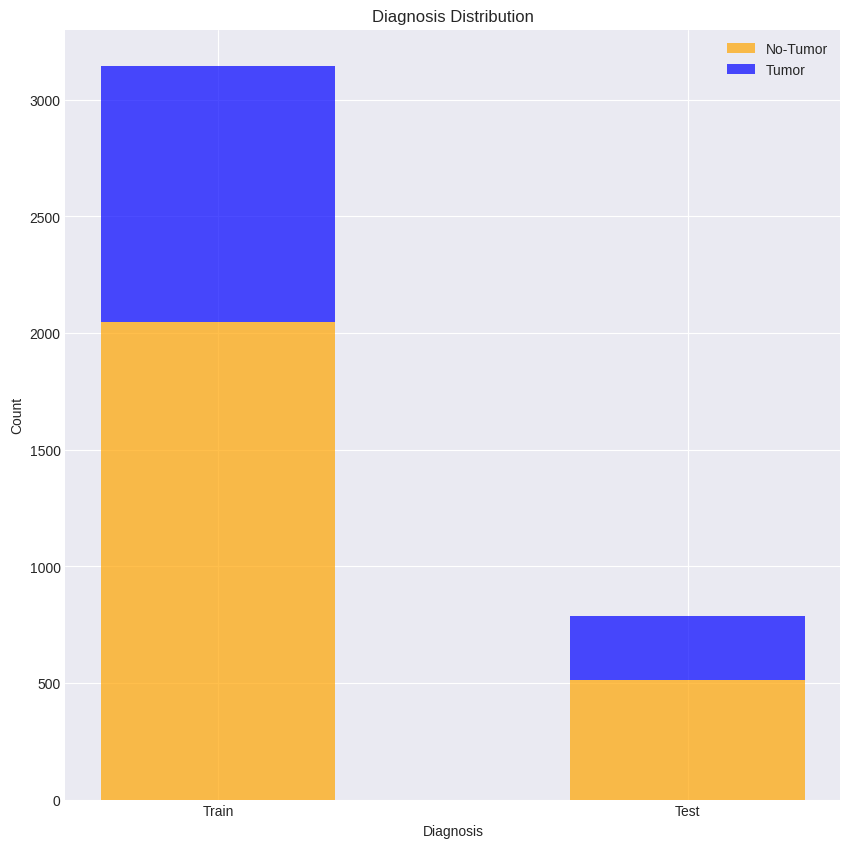

In [5]:
train_counts = train_info['Diagnosis'].value_counts()
test_counts = test_info['Diagnosis'].value_counts()

stacks = {
    'No-Tumor': [train_counts['No-Tumor'], test_counts['No-Tumor']],
    'Tumor': [train_counts['Tumor'], test_counts['Tumor']]
}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
width = 0.5

ax.bar(['Train', 'Test'], stacks['No-Tumor'], color='orange', alpha=0.7, linewidth=2, label='No-Tumor', width=width)
ax.bar(['Train', 'Test'], stacks['Tumor'], color='blue', alpha=0.7, linewidth=2, label='Tumor', bottom=stacks['No-Tumor'], width=width)
ax.set_title('Diagnosis Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Diagnosis')
ax.legend()
plt.show()

In [6]:
distribution = pd.DataFrame(columns=['Train', 'Test'], index=['No-Tumor', 'Tumor'], data=np.array([train_counts / train_counts.sum(), test_counts / test_counts.sum()]).T) 

# show df as percentage str
distribution = distribution.map(lambda x: f'{x:.2%}')
distribution

,Train,Test
No-Tumor,65.07%,65.01%
Tumor,34.93%,34.99%


In [7]:
N_SAMPLES = 6
# choose N_SAMPLES random images from the train set
tumor_samples = train_info[train_info['Diagnosis'] == 'Tumor'].sample(N_SAMPLES)['ID'].index.values
no_tumor_samples = train_info[train_info['Diagnosis'] == 'No-Tumor'].sample(N_SAMPLES)['ID'].index.values

dataset = LGGSegmentationDataset(DATASET_PATH, split=DataSplit.TRAIN, include_non_tumor=True)

transformer = DualInputTransform(ToTensor())

pairs_tumor = [transformer(*dataset._get_image_mask(i)) for i in tumor_samples]
pairs_no_tumor = [transformer(*dataset._get_image_mask(i)) for i in no_tumor_samples]


### Positive Images and Masks

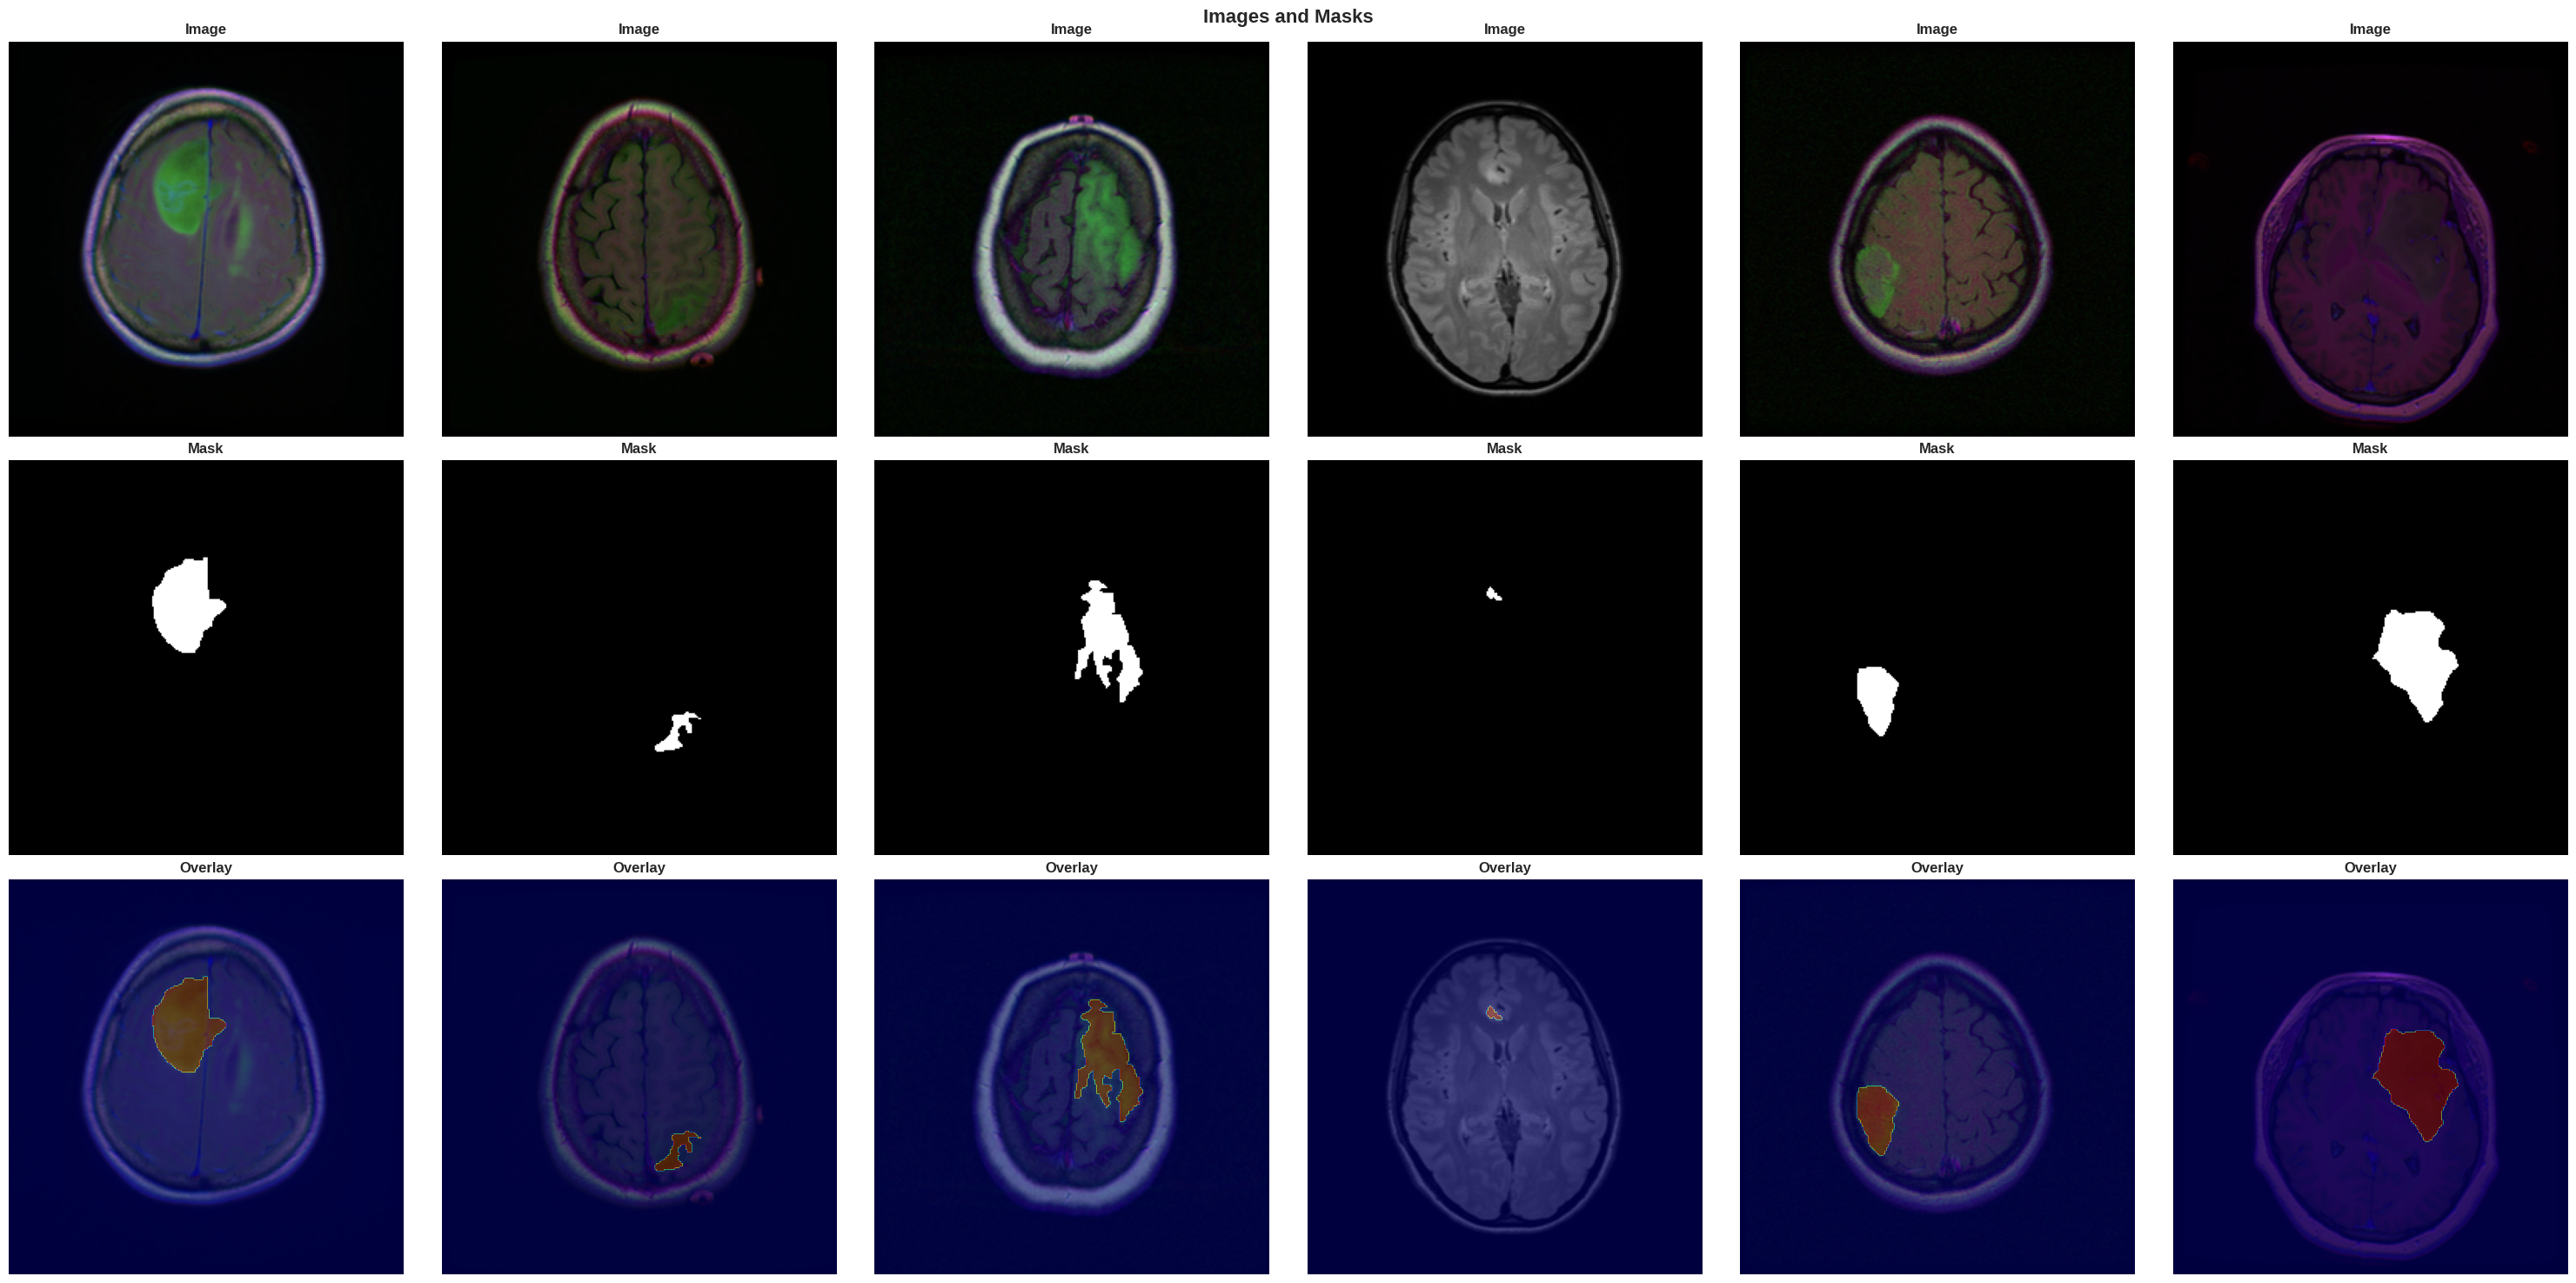

In [8]:
tumor_images, tumor_masks = zip(*pairs_tumor)

plot_images_and_masks(tumor_images, tumor_masks, include_overlay=True)

### Negative Images and Masks

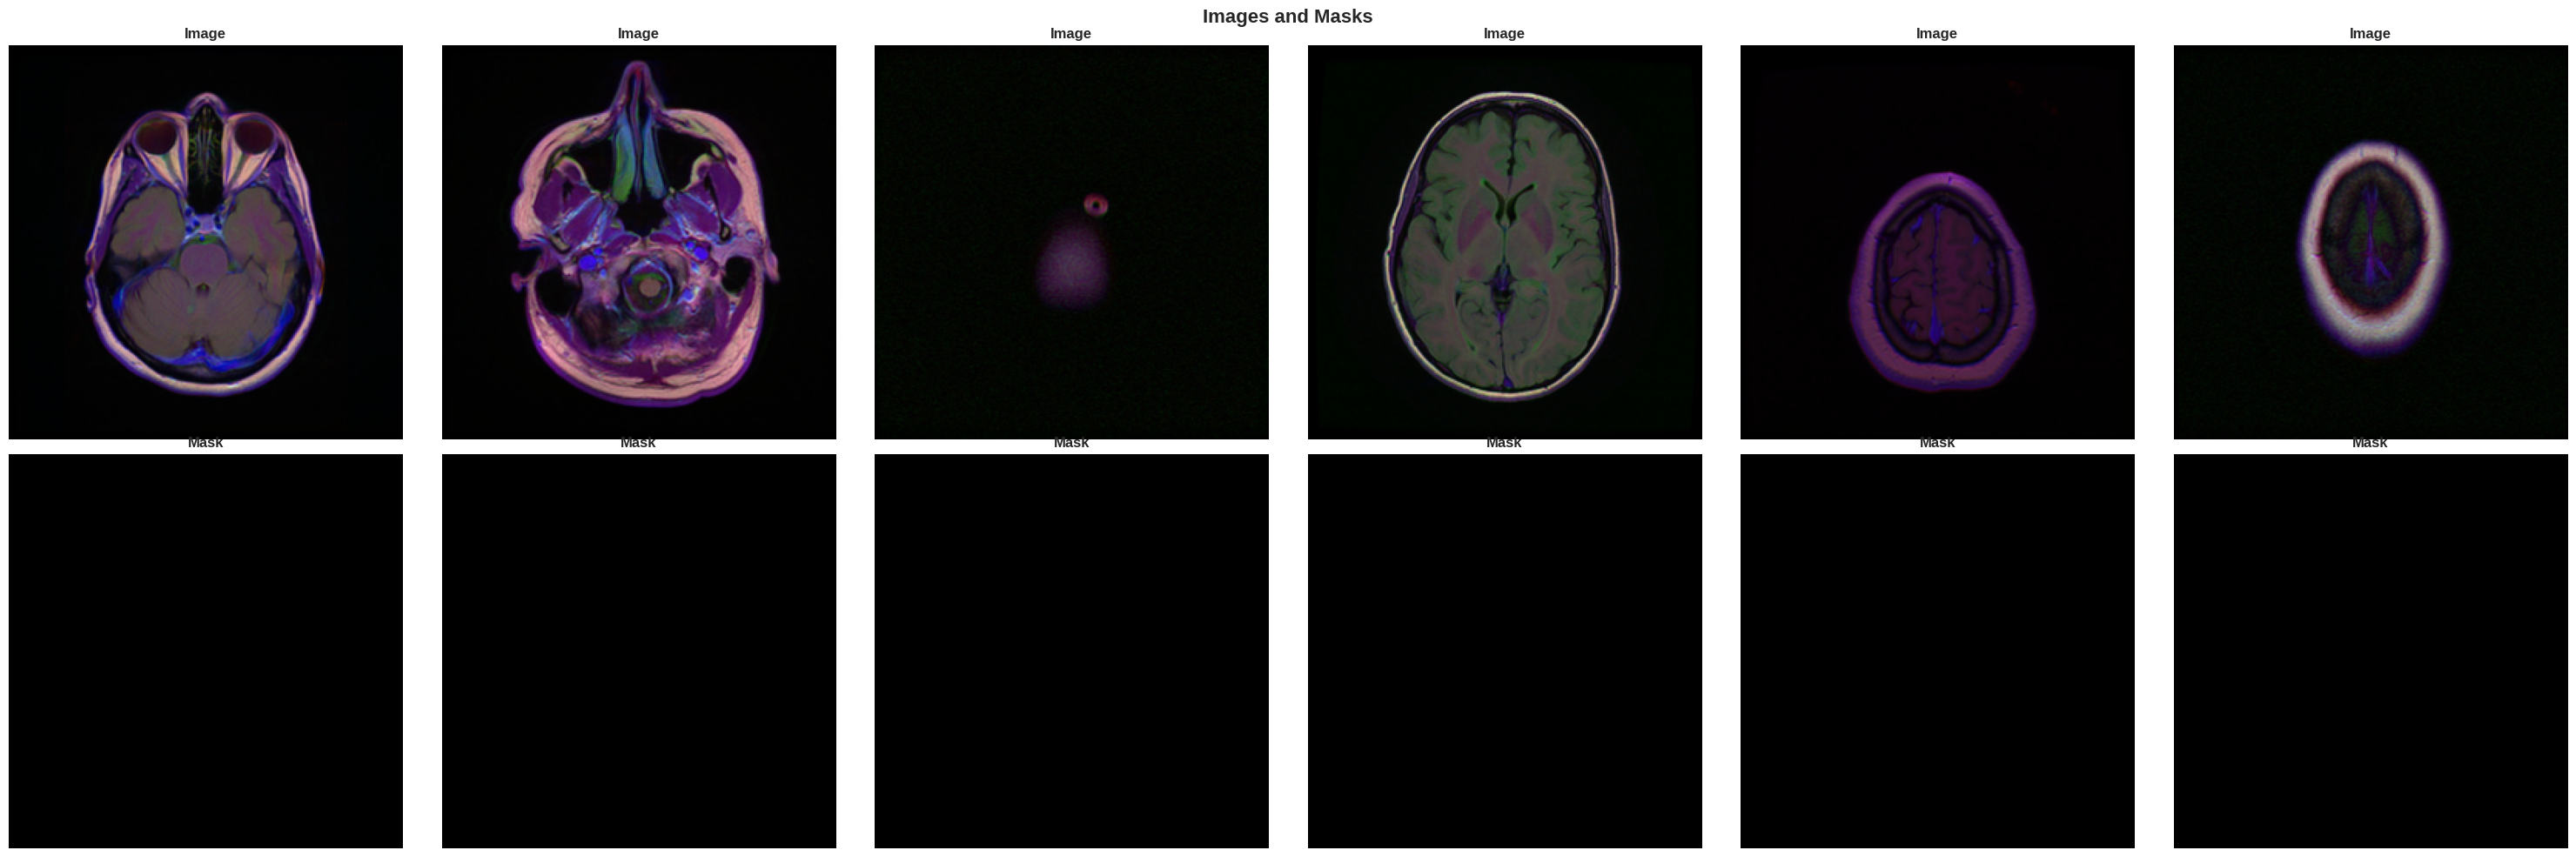

In [9]:
no_tumor_images, no_tumor_masks = zip(*pairs_no_tumor)
plot_images_and_masks(no_tumor_images, no_tumor_masks, include_overlay=False)

### Finding distributions of pixels values across training set

In [13]:
def get_mean_std(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += batch_size
    
    mean /= total
    std /= total

    return mean, std

transformer = DualInputCompose([
    DualInputResize((320, 320)),
    DualInputTransform(ToTensor()),

])

dataset = LGGSegmentationDataset(DATASET_PATH, split=DataSplit.TRAIN, transform=transformer)


loader = DataLoader(dataset, batch_size=4, shuffle=True)

mean, std = get_mean_std(loader)
print(f'Mean of train dataset: {mean}')
print(f'Std of train dataset: {std}')

Mean of train dataset: tensor([0.1047, 0.0965, 0.0985])
Std of train dataset: tensor([0.1201, 0.1200, 0.1225])
